We have derived the vertical velocity w using xgc and the vozocrtx and vomecrty variables. This is to determine in which direction a positive w is

In [8]:
import datetime
import pathlib

from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4_3D
import parcels
import xarray

from parcels import logger, XarrayDecodedFilter

logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

# Subset, lower left corner of my grid
enatl_data_path = pathlib.Path("day_1_5")
zero_uvw_data_path = pathlib.Path("enatl60_uvw_zero")
constant_w_data_path = pathlib.Path("enatl60_w_constant")
u_files = sorted(zero_uvw_data_path.glob("*1d_vozocrtx*"))
v_files = sorted(zero_uvw_data_path.glob("*1d_vomecrty*"))
w_files = sorted(constant_w_data_path.glob("*1d_vovecrtz*"))

assert len(u_files) == len(w_files)
assert len(u_files) == len(v_files)

enatl_mesh_mask_file = enatl_data_path / "mesh_mask_eNATL60FARSHE_3.6.nc"

In [9]:
filenames = {
    "U": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": u_files,
    },
    "V": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": v_files,
    },
    "W": {
        "lon": enatl_mesh_mask_file,
        "lat": enatl_mesh_mask_file,
        "depth": w_files[0],
        "data": w_files,
    },
}

variables = {
    "U": "vozocrtx",
    "V": "vomecrty",
    "W": "vovecrtz",
}

dimensions = {
    "U": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "V": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "W": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
}

In [10]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [11]:
fieldset.U.grid.time

array([     0.,  86400., 172800., 259200., 345600.])

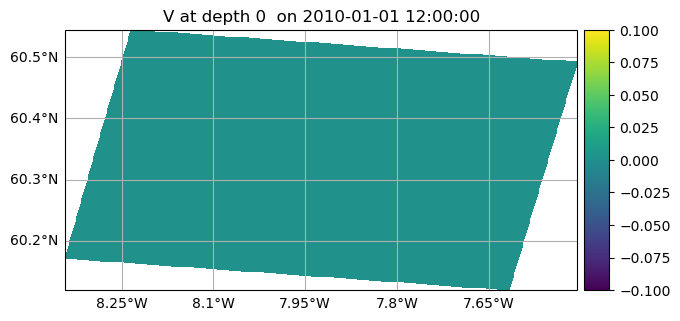

In [12]:
fieldset.V.show()

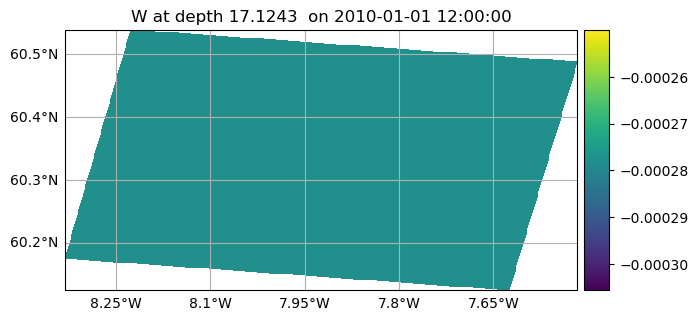

In [13]:
fieldset.W.show(depth_level=10)

In [14]:
start_point = (-7.883789, 60.239120)  # y_c = 9, x_r = 21
stop_point = (-7.857898, 60.327419)  # y_c = 18, x_r = 21
depth = 400.0

pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=10,
    start=start_point,
    finish=stop_point,
    depth=depth,
)
kernels = pset.Kernel(AdvectionRK4_3D)

In [15]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [16]:
output_file = pset.ParticleFile(
    name="output_w_cont.zarr", outputdt=datetime.timedelta(hours=6)
)
starttime = datetime.datetime(2010, 1, 1, 12)
endtime = starttime + datetime.timedelta(days=4)
runtime = endtime - starttime

pset.execute(
    kernels,
    runtime=runtime,
    dt=datetime.timedelta(hours=6),
    output_file=output_file,
    recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/libf193868c8bb5b6f2eaaa2a133ecc76d9_0.so


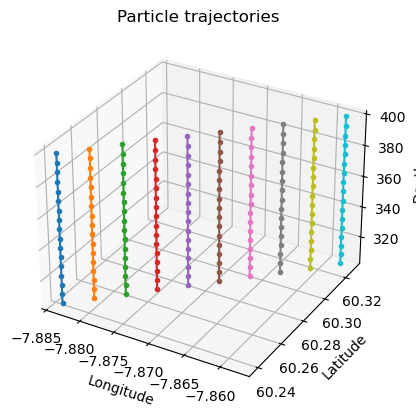

<module 'matplotlib.pyplot' from '/Users/niten/.local/anaconda/envs/opt-m1-lagrangian/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [17]:
parcels.plotTrajectoriesFile("output_w_cont.zarr", mode="3d")

In [19]:
pset = xarray.open_zarr("output_w_cont.zarr")
pset.isel(obs=-1).z.values

array([303.99999768, 303.99999768, 303.99999768, 303.99999768,
       303.99999768, 303.99999768, 303.99999768, 303.99999768,
       303.99999768, 303.99999768])